In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data\sample_submission.csv
data\test.csv
data\train.csv


In [9]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms, models

from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [10]:
train = pd.read_csv('data/train.csv', dtype=np.float32)
test = pd.read_csv('data/test.csv', dtype=np.float32)
sample_hub = pd.read_csv('data/sample_submission.csv')

In [12]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


In [16]:
targets_np = train.label.values
features_np = train.iloc[:, 1:].values/255 # Нормализуем значения пикселей от 0 до 1

X_train, X_test, y_train, y_test = train_test_split(features_np, targets_np, test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [19]:
# Konversi dari Arrays ke Tensors

class DigitDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
torch.manual_seed(1111)
train_dataset = DigitDataset(X_train, y_train)
test_dataset = DigitDataset(X_test, y_test)
len(train_dataset)

33600

In [21]:
train_dataset.X.shape

torch.Size([33600, 784])

In [22]:
batch_size = 64
g = torch.Generator()
g.manual_seed(1111)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=g)

In [27]:
len(train_loader) #batch size

525

In [38]:
train_loader.dataset.X.shape

torch.Size([33600, 784])

In [14]:
def plot_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28,28), cmap='bone')
        ax.axis('off')
    #plt.title('handwritten digit')
    plt.show()

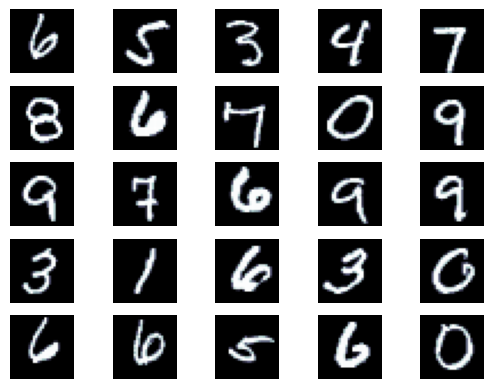

In [15]:
N_IMAGES = 25

images = [image for image, label in [train_dataset[i] for i in range(N_IMAGES)]]

plot_images(images)

In [16]:
class MLPdigit(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_dim)

        self.dropout = nn.Dropout(p=0.2)
        #self.sftmax = F.softmax

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)

        return x
        


In [17]:
input_dim = 28 * 28
output_dim = 10
lr=0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPdigit(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [18]:
def cal_accuracy(y_pred, y):
    predicted = torch.argmax(y_pred, dim=-1)
    correct = (predicted == y).sum()
    acc = correct.float() / y.shape[0]
    return acc


In [19]:
def train(model, train_loader, optimizer, criterion, device):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for X, y in train_loader:
        y_pred = model(X).to(device)        
        
        loss = criterion(y_pred, y)

        acc = cal_accuracy(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss/len(train_loader), epoch_acc/len(train_loader)        


In [20]:
def evaluate(model, test_loader, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X).to(device)
            loss = criterion(y_pred, y)
            acc = cal_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss/len(test_loader), epoch_acc/len(test_loader)

In [21]:
best_valid_loss = 0
EPOCHS = 15
train_losses, test_losses, train_accs, valid_accs = [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'digit-model.pt')

    print(f'Epoch: {epoch}')
    print(f'\t Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f}')
    print(f'\t  Val  loss: {valid_loss:.3f} |   Val acc: {valid_acc:.3f}')

Epoch: 0
	 Train loss: 0.482 | Train acc: 0.849
	  Val  loss: 0.185 |   Val acc: 0.943
Epoch: 1
	 Train loss: 0.176 | Train acc: 0.950
	  Val  loss: 0.137 |   Val acc: 0.960
Epoch: 2
	 Train loss: 0.128 | Train acc: 0.964
	  Val  loss: 0.117 |   Val acc: 0.967
Epoch: 3
	 Train loss: 0.105 | Train acc: 0.969
	  Val  loss: 0.105 |   Val acc: 0.969
Epoch: 4
	 Train loss: 0.083 | Train acc: 0.976
	  Val  loss: 0.140 |   Val acc: 0.960
Epoch: 5
	 Train loss: 0.077 | Train acc: 0.978
	  Val  loss: 0.090 |   Val acc: 0.974
Epoch: 6
	 Train loss: 0.064 | Train acc: 0.981
	  Val  loss: 0.091 |   Val acc: 0.975
Epoch: 7
	 Train loss: 0.058 | Train acc: 0.983
	  Val  loss: 0.094 |   Val acc: 0.973
Epoch: 8
	 Train loss: 0.052 | Train acc: 0.985
	  Val  loss: 0.107 |   Val acc: 0.973
Epoch: 9
	 Train loss: 0.049 | Train acc: 0.986
	  Val  loss: 0.106 |   Val acc: 0.973
Epoch: 10
	 Train loss: 0.044 | Train acc: 0.987
	  Val  loss: 0.094 |   Val acc: 0.978
Epoch: 11
	 Train loss: 0.038 | Train acc:

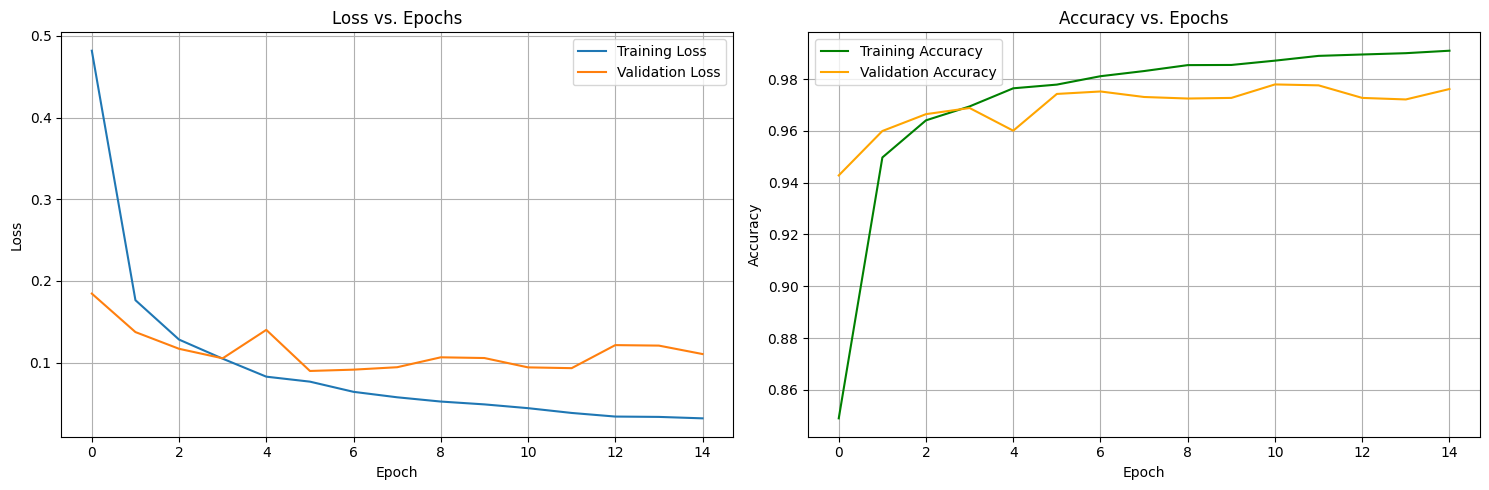

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Losses ---
ax1.plot(train_losses, label='Training Loss')
ax1.plot(test_losses, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Accuracies ---
ax2.plot(train_accs, label='Training Accuracy', color='green')
ax2.plot(valid_accs, label='Validation Accuracy', color='orange')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()